# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

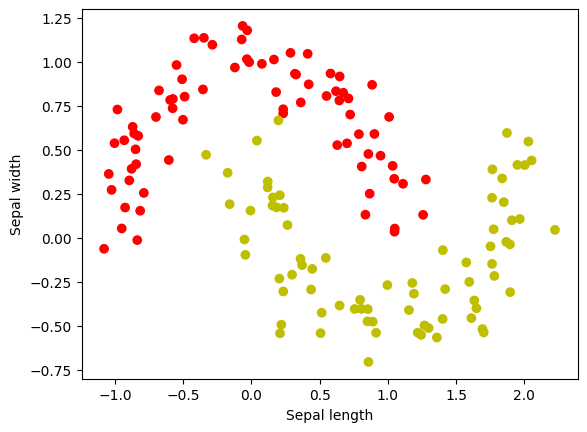

In [ ]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
        )

    def forward(self, x):
        x = self.dense(x)
        return x

# Crie uma instância do modelo modificado
model = Modelo()


## _predict_ utilizada para predição de classes e na visualização

In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [ ]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0036)


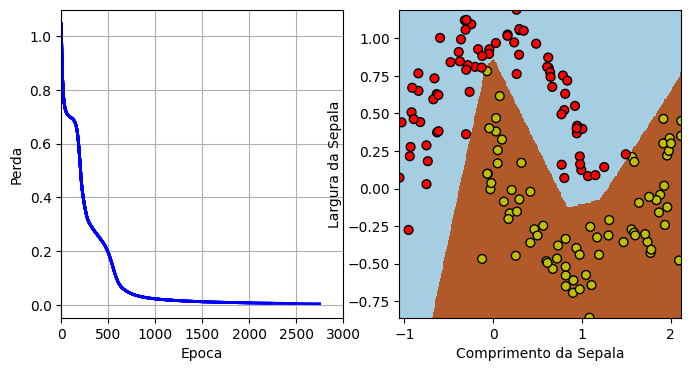

In [ ]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [ ]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([10, 2])
tensor([[-2.0454,  0.5430],
        [-0.5082, -0.0990],
        [ 0.6325, -0.3421],
        [-0.2663,  0.6262],
        [-1.1435, -0.6362],
        [ 1.1576,  0.5506],
        [ 1.4361, -1.0511],
        [-0.4691,  0.1220],
        [-1.3664, -0.5048],
        [-0.8727, -0.3447]])
dense.0.bias    torch.Size([10])
tensor([-0.4643, -0.6022,  0.3804,  0.5926,  1.3411, -0.3502, -1.3480, -0.5525,
         0.2993,  0.2096])
dense.2.weight  torch.Size([10, 10])
tensor([[-0.0438,  0.2199,  0.0663,  0.0953,  0.1155,  0.0799, -0.0650, -0.1027,
          0.1500, -0.2367],
        [ 0.0275,  0.0163, -0.1836, -0.2933,  0.2102, -0.0168, -0.2514, -0.0426,
         -0.3008, -0.0992],
        [ 0.2143,  0.2705,  0.2131,  0.3784, -0.2095,  0.3526, -0.2442,  0.1328,
         -0.1211,  0.2477],
        [-1.4707,  0.0662,  0.3212, -0.3926,  1.3031, -0.6025,  1.5505,  0.1046,
         -0.9915, -0.6756],
        [-0.1717, -0.2097,  0.0248,  0.0450, -0.1052, -0.3055, -0.1995

### Avaliação do classificador

In [ ]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,75,0
1,0,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

1.

Ao incrementar a quantidade de neurônios e camadas na rede neural, percebi que os pesos finais se tornaram mais diversificados e complexos. Isso indica que o modelo está aprendendo representações mais sofisticadas dos dados de entrada, o que pode resultar em uma melhor capacidade de generalização e desempenho em dados não vistos.

Entretanto, adicionar mais camadas e neurônios também eleva a complexidade do modelo, o que pode causar problemas de overfitting se não for bem controlado. Assim, é crucial monitorar o desempenho do modelo em um conjunto de validação e aplicar técnicas como regularização e dropout para evitar o overfitting.

Além disso, ao aumentar o número de neurônios e camadas, o tempo de treinamento também tende a crescer significativamente devido ao aumento da complexidade computacional. Portanto, é importante equilibrar a capacidade do modelo com a eficiência computacional ao projetar redes neurais mais complexas.

2.

Substituindo a função de ativação ReLU pela Sigmoid, a principal diferença é que a Sigmoid gera saídas no intervalo de [0, 1], enquanto a ReLU produz saídas não negativas. Isso pode influenciar o treinamento da rede neural de várias maneiras:

Gradientes Menores: A função Sigmoid tende a ter derivadas menores em comparação com a ReLU, o que pode resultar em gradientes menores durante o treinamento. Isso pode tornar o treinamento mais lento e menos eficiente, especialmente em redes profundas.

Convergência Mais Lenta: Devido aos gradientes menores, o modelo pode demorar mais para convergir durante o treinamento, exigindo ajustes adicionais nos hiperparâmetros, como a taxa de aprendizado.

Restrição da Saída: Como a Sigmoid produz saídas no intervalo de [0, 1], a saída da rede será limitada a esse intervalo. Isso pode restringir a capacidade da rede de representar relações complexas nos dados.

3.

Quando não se utiliza uma função de ativação não linear entre as camadas de uma rede neural, o modelo se reduz a uma série de transformações lineares. Isso significa que, mesmo com múltiplas camadas, a rede neural se comporta como se tivesse apenas uma única camada.

Sem a ativação não linear, cada camada da rede neural realiza apenas uma combinação linear das entradas, seguida por uma função linear (como a identidade). Como resultado, a rede neural não consegue aprender representações complexas dos dados e não pode capturar relações não lineares entre as características de entrada e a saída.

Em resumo, a ausência de ativação não linear limita severamente a capacidade da rede neural de modelar dados complexos, tornando-a incapaz de resolver problemas que exigem aprendizado de padrões não lineares.

## Principais aprendizados